In [21]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from scipy import integrate

import tables as tb

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from matplotlib import style
style.use('ggplot')

DATA_PATH = "D:\\LANLEarthquakeData"
TRAIN_DATA_PATH = f"{DATA_PATH}\\train.csv"
TEST_SEG_PATH = f"{DATA_PATH}\\test"
TRAIN_SEG_PATH = f"{DATA_PATH}\\train"
SUBMISSON_PATH = f"{DATA_PATH}\\sample_submission.csv"
TRAINING_DERIVED_ROW_COUNT = 150_000
READ_WHOLE_TRAIN_DATA = True
READ_WHOLE_TEST_DATA = True
NP_DATA_PATH = f"{DATA_PATH}\\np"
PICKLE_PATH = f"{DATA_PATH}\\pickle"

TOTAL_ROW_COUNT = 629145480

def integrate_cumtrapz(x, how='cumtrapz',i=0):
    '''Numerically integrate the time series.
    @param how: the method to use (trapz by default)
    @return 
    Available methods:
     * trapz - trapezoidal
     * cumtrapz - cumulative trapezoidal
     * simps - Simpson's rule
     * romb - Romberger's rule     
     '''
    y=x
    return integrate.cumtrapz(y,x,initial=i)

In [2]:
%%time
df = pd.read_csv(TRAIN_DATA_PATH, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 2min 20s


In [3]:
%%time
#df = df.rename(columns={"acoustic_data": "acc", "time_to_failure": "time"})
rows = TRAINING_DERIVED_ROW_COUNT
segments = int(np.floor(df.shape[0] / rows))
print(segments)

4194
Wall time: 2 ms


In [4]:
%%time
df_train = pd.DataFrame(index=range(segments), columns=['time','acc','vel','disp'])
last_vel = 0
last_disp = 0
for segment in tqdm(range(segments)):
    seg = df.iloc[segment*rows:segment*rows+rows]
    
    time = seg['time_to_failure'].values[-1]
    df_train.loc[segment, 'time'] = time    
    
    acc = seg['acoustic_data'].values
    df_train.loc[segment, 'acc'] = acc
    
    vel = integrate_cumtrapz(acc,last_vel)
    last_vel = vel[-1:]
    df_train.loc[segment, 'vel'] = vel
        
    disp = integrate_cumtrapz(vel,last_disp)    
    last_disp = disp[-1:]
    df_train.loc[segment, 'disp'] = disp


Wall time: 1min 8s


In [6]:
del df

In [7]:
for i in range(0, df_train.shape[0], 1000):
    df_chunk = df_train[i:i+1000]
    df_chunk.to_pickle(f"{PICKLE_PATH}\\Samples{i}.pickle")

In [8]:
df_train

,time,acc,vel,disp
0,1.4308,"[12, 6, 8, 5, 8, 8, 9, 7, -5, 3, 5, 2, 2, 3, -...","[0.0, -54.0, -40.0, -59.5, -40.0, -40.0, -31.5...","[0.0, 1458.0, 800.0, 1770.125, 800.0, 800.0, 4..."
1,1.3915,"[5, 6, 8, 6, 3, -1, 5, 4, 4, 4, 6, 5, 5, 5, 6,...","[0.0, 5.5, 19.5, 5.5, -8.0, -12.0, 0.0, -4.5, ...","[0.0, 15.125, 190.125, 15.125, 32.0, 72.0, 0.0..."
2,1.3532,"[5, 5, 8, 9, 9, 10, 11, 12, 13, 5, 3, 7, 5, 3,...","[0.0, 0.0, 19.5, 28.0, 28.0, 37.5, 48.0, 59.5,...","[0.0, 0.0, 190.125, 392.0, 392.0, 703.125, 115..."
3,1.3138,"[5, -5, -4, 1, 3, 4, 6, 12, 15, 17, 14, 9, 6, ...","[0.0, 0.0, -4.5, -12.0, -8.0, -4.5, 5.5, 59.5,...","[0.0, 0.0, 10.125, 72.0, 32.0, 10.125, 15.125,..."
4,1.2744,"[12, 6, 4, -1, 0, 6, 7, 6, 2, -2, 0, 4, 1, 5, ...","[0.0, -54.0, -64.0, -71.5, -72.0, -54.0, -47.5...","[0.0, 1458.0, 2048.0, 2556.125, 2592.0, 1458.0..."
5,1.2361,"[14, 7, 8, 1, 4, 1, 3, 5, 3, 2, 5, 3, 0, 0, 5,...","[0.0, -73.5, -66.0, -97.5, -90.0, -97.5, -93.5...","[0.0, 2701.125, 2178.0, 4753.125, 4050.0, 4753..."
6,1.1968,"[0, 6, 3, 0, 3, 7, 9, 0, 6, 9, 10, 5, 3, 9, 11...","[0.0, 18.0, 4.5, 0.0, 4.5, 24.5, 40.5, 0.0, 18...","[0.0, 162.0, 10.125, 0.0, 10.125, 300.125, 820..."
7,1.1585,"[3, 2, 6, 6, 6, -2, -1, -1, 9, 6, 3, 7, 11, 10...","[0.0, -2.5, 13.5, 13.5, 13.5, -2.5, -4.0, -4.0...","[0.0, 3.125, 91.125, 91.125, 91.125, 3.125, 8...."
8,1.1191,"[1, 4, 2, -1, -2, 3, 4, 4, 7, 7, 11, 8, 7, 3, ...","[0.0, 7.5, 1.5, 0.0, 1.5, 4.0, 7.5, 7.5, 24.0,...","[0.0, 28.125, 1.125, 0.0, 1.125, 8.0, 28.125, ..."
9,1.0797,"[5, 5, 6, 6, 9, 8, 5, 12, 5, 3, 5, 3, 4, 6, 3,...","[0.0, 0.0, 5.5, 5.5, 28.0, 19.5, 0.0, 59.5, 0....","[0.0, 0.0, 15.125, 15.125, 392.0, 190.125, 0.0..."


In [58]:
df_train[1:2]["time"].values

array([1.3914989], dtype=object)

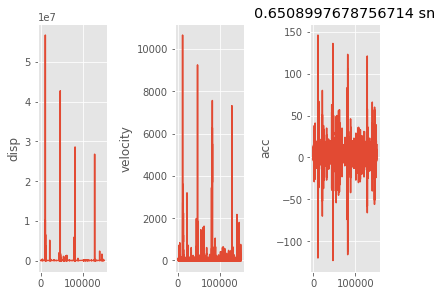

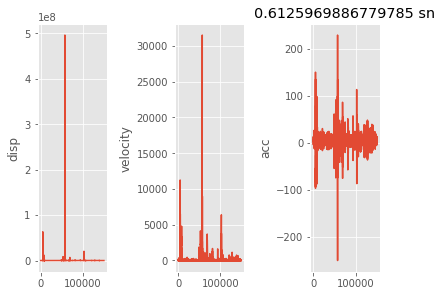

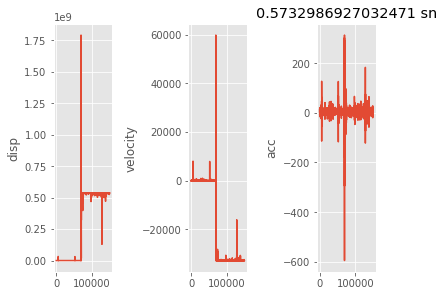

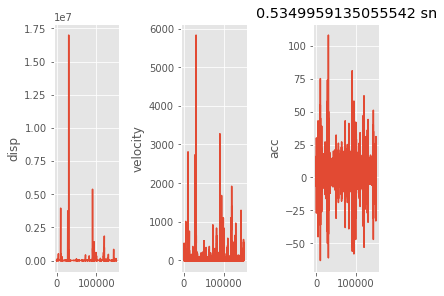

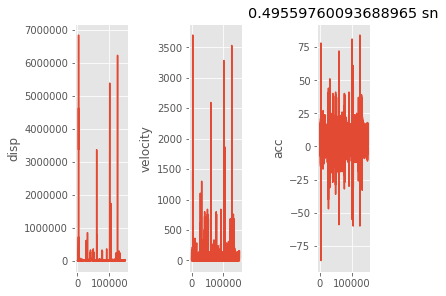

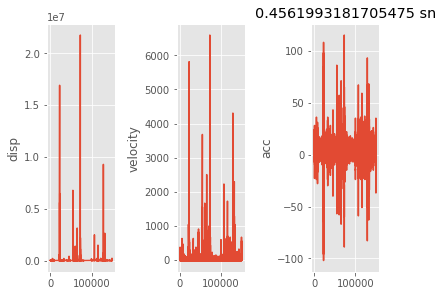

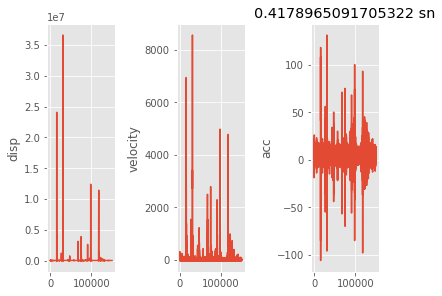

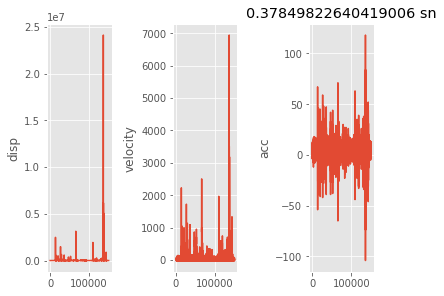

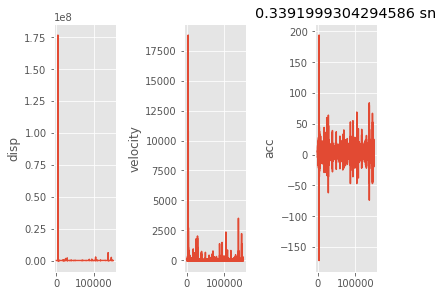

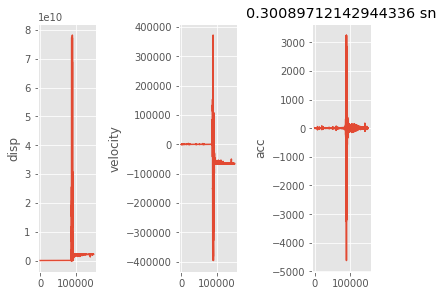

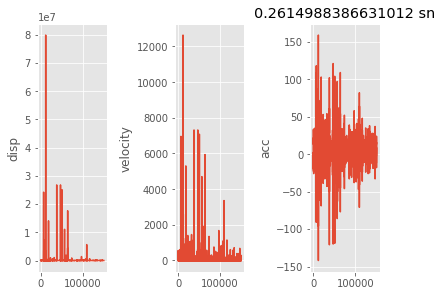

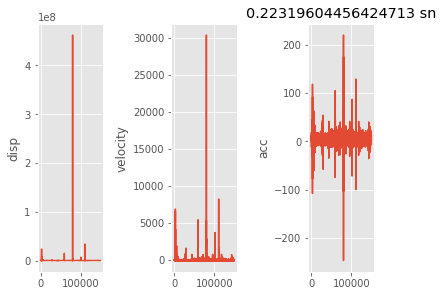

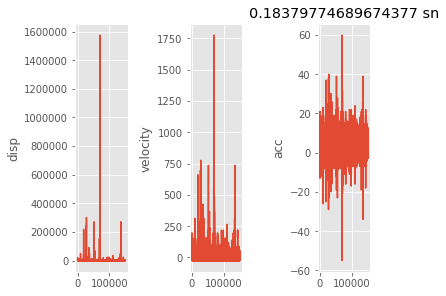

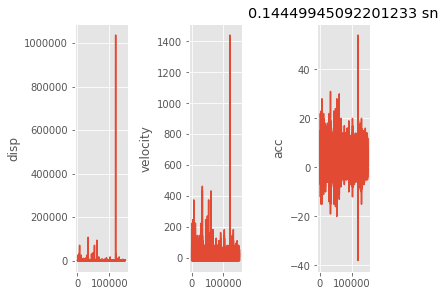

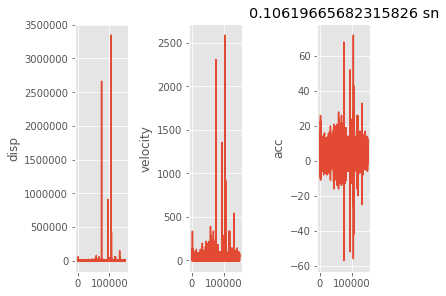

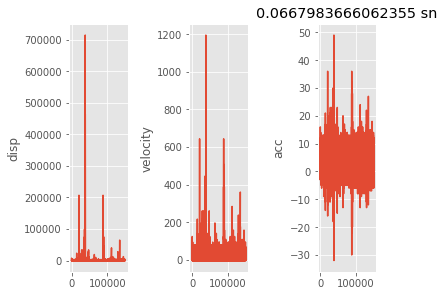

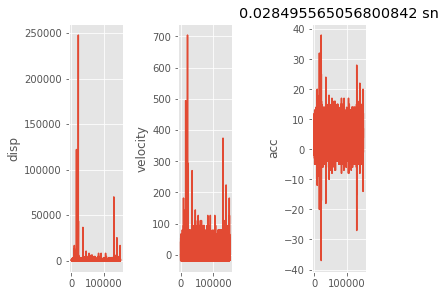

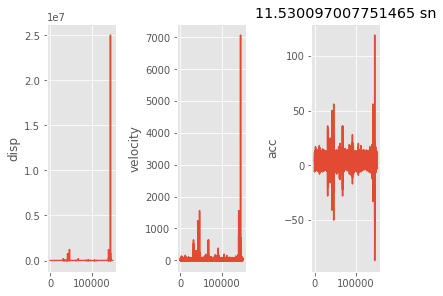

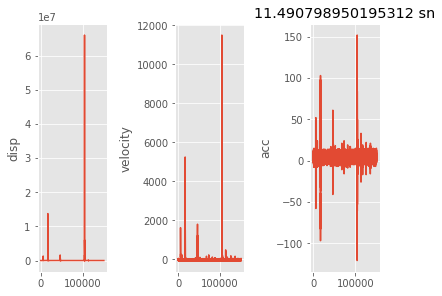

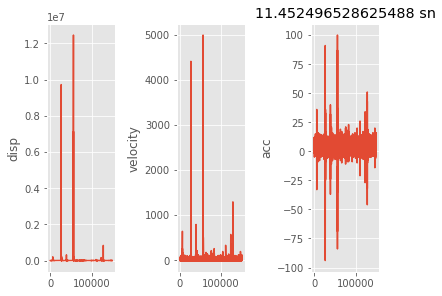

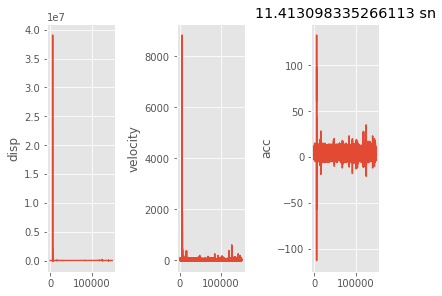

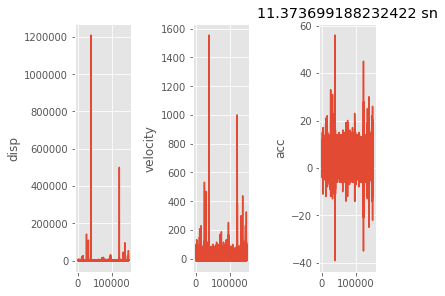

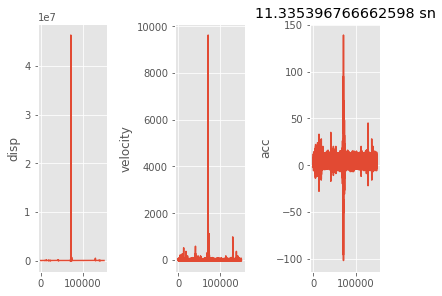

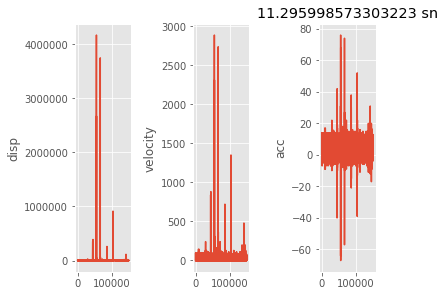

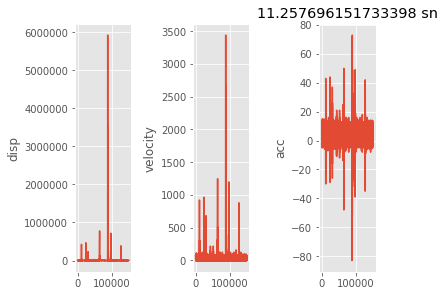

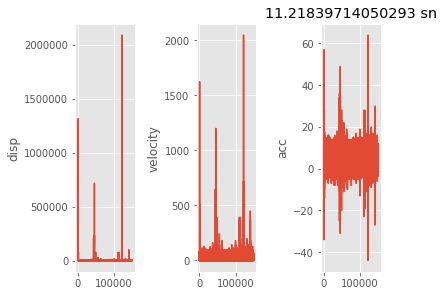

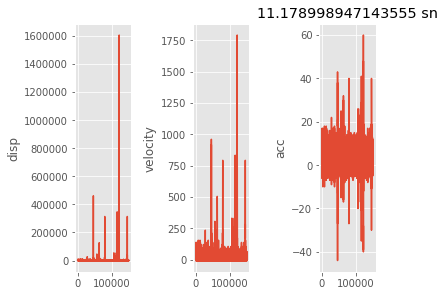

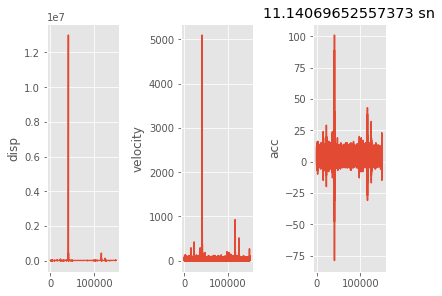

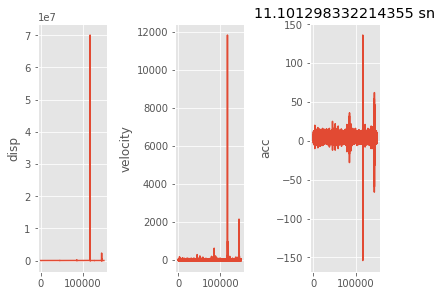

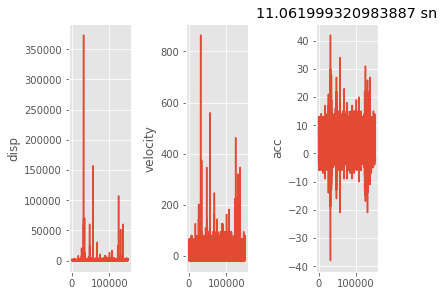

In [61]:
for i in range(20,50):
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(1, 3, figure=fig)

    ax = fig.add_subplot(gs[0, 0])
    ax.plot(df_train[i:i+1]["disp"].values[0])
    ax.set_ylabel('disp')

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(df_train[i:i+1]["vel"].values[0])
    ax1.set_ylabel('velocity')

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(df_train[i:i+1]["acc"].values[0])
    ax2.set_ylabel('acc')

    plt.title(f'{df_train[i:i+1]["time"].values[0]} sn')
    plt.show()